In [1]:
import os
import plaid
import requests
import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def pretty_print_response(response):
  print(json.dumps(response, indent=4, sort_keys=True))

In [3]:
PLAID_CLIENT_ID = os.getenv('PLAID_CLIENT_ID')
PLAID_SBX_SECRET_KEY = os.getenv('PLAID_SBX_SECRET_KEY')
PLAID_PUBLIC_KEY = os.getenv('PLAID_PUBLIC_KEY')
PLAID_ENV = os.getenv('PLAID_ENV', 'sandbox')
PLAID_PRODUCTS = os.getenv('PLAID_PRODUCTS', 'transactions')

# Plaid Access Token

In this section, you will use the plaid-python api to generate the correct authentication tokens to access data in the free developer Sandbox. This mimics how you might connect to your own account or a customer account, but due to privacy issues, this homework will only require connecting to and analyzing the fake data from the developer sandbox that Plaid provides. 

Complete the following steps to generate an access token:
1. Create a client to connect to plaid
2. Use the client to generate a public token and request the following items: 
['transactions', 'income', 'assets']
3. Exchange the public token for an access token
4. Test the access token by requesting and printing the available test accounts

### 1. Create a client to connect to plaid

In [4]:
INSTITUTION_ID = "ins_109508"

In [5]:
client = plaid.Client(client_id=PLAID_CLIENT_ID, secret=PLAID_SBX_SECRET_KEY, public_key=PLAID_PUBLIC_KEY, environment='sandbox')

### 2. Generate a public token

In [6]:
create_tkn_response = client.Sandbox.public_token.create(INSTITUTION_ID, ['transactions','income','assets'])

### 3. Exchange the public token for an access token

In [7]:
exchange_response = client.Item.public_token.exchange(create_tkn_response['public_token'])

### 4. Fetch Accounts

In [8]:
access_token = exchange_response['access_token']

---

# Account Transactions with Plaid

In this section, you will use the Plaid Python SDK to connect to the Developer Sandbox account and grab a list of transactions. You will need to complete the following steps:


1. Use the access token to fetch the transactions for the last 90 days
2. Print the categories for each transaction type
3. Create a new DataFrame using the following fields from the JSON transaction data: `date, name, amount, category`. (For categories with more than one label, just use the first category label in the list)
4. Convert the data types to the appropriate types (i.e. datetimeindex for the date and float for the amount)

### 1. Fetch the Transactions for the last 90 days

In [9]:
start_date = '{:%Y-%m-%d}'.format(datetime.datetime.now() + datetime.timedelta(-90))
end_date = '{:%Y-%m-%d}'.format(datetime.datetime.now()) 
transactions_response = client.Transactions.get(access_token, start_date, end_date)
# transactions_response

### 2. Print the categories for each transaction

In [10]:
categories=[]
for transactions in transactions_response['transactions']:
    categories.append(transactions['category'][0])
print(categories)

['Payment', 'Travel', 'Transfer', 'Transfer', 'Recreation', 'Travel', 'Food and Drink', 'Food and Drink', 'Food and Drink', 'Transfer', 'Travel', 'Travel', 'Food and Drink', 'Payment', 'Food and Drink', 'Shops']


### 3. Create a new DataFrame using the following fields from the JSON transaction data: date, name, amount, category. 

(For categories with more than one label, just use the first category label in the list)

In [11]:
# Create empty lists for data we are interested in, move through the transactions dictionary inside of the transactions response dictionary.
# put each list into a new dictionary
dictionary={}
Dates=[]
Amount=[]
Name=[]
for transactions in transactions_response['transactions']:
        Dates.append(transactions['date'])
        Amount.append(transactions['amount'])
        Name.append(transactions['name'])
dictionary = {'Dates':Dates,
        'Name':Name,
       'Amount':Amount,
       'Category':categories}

In [12]:
# Turn that dictionary into a dataframe.
transactions_df=pd.DataFrame(data=dictionary)

### 4. Convert the data types to the appropriate types 

(i.e. datetimeindex for the date and float for the amount)

In [13]:
transactions_df["Dates"]=pd.to_datetime(transactions_df["Dates"])
transactions_df.set_index(transactions_df["Dates"],inplace=True)

In [14]:
transactions_df.drop(columns=['Dates'],inplace=True)

In [17]:
transactions_df["Amount"] = transactions_df["Amount"].astype('float')
transactions_df

,Name,Amount,Category
Dates,,,
2020-01-16,CREDIT CARD 3333 PAYMENT *//,25.00,Payment
2020-01-16,Uber 063015 SF**POOL**,5.40,Travel
2020-01-15,ACH Electronic CreditGUSTO PAY 123456,5850.00,Transfer
2020-01-15,CD DEPOSIT .INITIAL.,1000.00,Transfer
2020-01-14,Touchstone Climbing,78.50,Recreation
2020-01-14,United Airlines,-500.00,Travel
2020-01-13,McDonald's,12.00,Food and Drink
2020-01-13,Starbucks,4.33,Food and Drink
2020-01-12,SparkFun,89.40,Food and Drink


---

# Income Analysis with Plaid

In this section, you will use the Plaid Sandbox to complete the following:
1. Determine the previous year's gross income and print the results
2. Determine the current monthly income and print the results
3. Determine the projected yearly income and print the results

In [16]:
# YOUR CODE HERE

---

# Budget Analysis
In this section, you will use the transactions DataFrame to analyze the customer's budget

1. Calculate the total spending per category and print the results (Hint: groupby or count transactions per category)
2. Generate a bar chart with the number of transactions for each category 
3. Calculate the expenses per month
4. Plot the total expenses per month

In [17]:
table_ctgry=pd.pivot_table(transactions_df, index='Dates',columns='Category',fill_value=0.00)


### Calculate the expenses per category

In [19]:
ctgry_sums=pd.DataFrame(data=table_ctgry.sum(axis=0))
ctgry_sums.reset_index(level='Category',inplace=True)

In [20]:
print(ctgry_sums['Category'])

Amount    Food and Drink
Amount           Payment
Amount        Recreation
Amount             Shops
Amount          Transfer
Amount            Travel
Name: Category, dtype: object


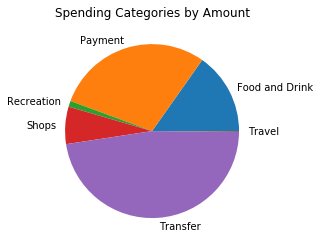

In [25]:
plt.pie(ctgry_sums[0],labels=ctgry_sums['Category'])
plt.title('Spending Categories by Amount')
plt.show()

In [27]:
ctgry_qty=pd.DataFrame(data=table_ctgry.count(axis=0))
ctgry_qty.reset_index(level='Category',inplace=True)
ctgry_qty

,Category,0
Amount,Food and Drink,10
Amount,Payment,10
Amount,Recreation,10
Amount,Shops,10
Amount,Transfer,10
Amount,Travel,10


### Calculate the expenses per month

In [ ]:
# YOUR CODE HERE